### Imports

In [37]:
# All imports

import glob
from PIL import Image
import os
import keras
import tensorflow as tf
import keras.utils
from keras.preprocessing import image
from keras import utils as np_util0s
import threading
from numpy import random
from bs4 import BeautifulSoup
import scipy
import matplotlib.pyplot as plt
import numpy as np
import os
from keras.callbacks import ModelCheckpoint, TensorBoard
from scipy.misc import imresize
from keras.layers import Input
from tiramisu import *
import datetime
from time import time
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.layers import Input

from skimage import data
from skimage.filters import threshold_otsu,median, gaussian
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb, rgb2gray

from skimage.morphology import disk
from skimage.filters.rank import median


%matplotlib inline

In [6]:
# Some memory thing

session_config = tf.ConfigProto(log_device_placement=False, allow_soft_placement=True)    
# please do not use the totality of the GPU memory
session_config.gpu_options.per_process_gpu_memory_fraction = 0.90

### Helper functions

In [13]:
get_img_num = lambda img_file: (int(os.path.basename(img_file).split('_')[0])) 

In [27]:
def load_image(img, img_sz=None): 
    if img_sz:
        return np.array(Image.open(img).resize(img_sz, Image.NEAREST))
    else:
        return np.array(Image.open(img))

In [40]:
def get_from_region_props(region_props,r):
    for i in region_props:
        if i.label==r:
            return i

### Samples of old and new segmentation maps

In [20]:
# Paths

root_dir = '/media/narita/Data/Neutrophils/fps_20_frames/5_07072016_Phagocytosis_DMSO/final/'
images_folder_name = 'frames'
new_segmentation_folder_name = 'segmentation_with_borders2/mask'
old_segmentation_folder_name = 'old_segmentation_with_borders2/mask'



In [21]:
#1 - Read some training images
cnt=0
img_files = []
path = os.path.join(root_dir)
images_folder_path = os.path.join(path,images_folder_name)
img_files.insert(cnt,sorted(glob.glob(images_folder_path+"/*.png")))
all_training_images = [item for sublist in img_files for item in sublist]


In [23]:
#all_training_images

In [28]:
#2- Randomly select few indices and display thei old and new segmentation maps
import random

random_img_ind =  np.random.randint(0,len(all_training_images),size=5)
images = []
new_maps = []
old_maps = []

for i,indx in enumerate(random_img_ind):
    current_img = all_training_images[indx]
    current_img_name = current_img.rsplit('/',1)[1].split('.')[0]
    new_segmentation_mask = os.path.join(root_dir,new_segmentation_folder_name,current_img_name+'.png')
    old_segmentation_mask = os.path.join(root_dir,old_segmentation_folder_name,current_img_name+'.png')
    
    images.insert(i,(load_image(current_img)))
    new_maps.insert(i,(load_image(new_segmentation_mask)))
    old_maps.insert(i,(load_image(old_segmentation_mask)))
    

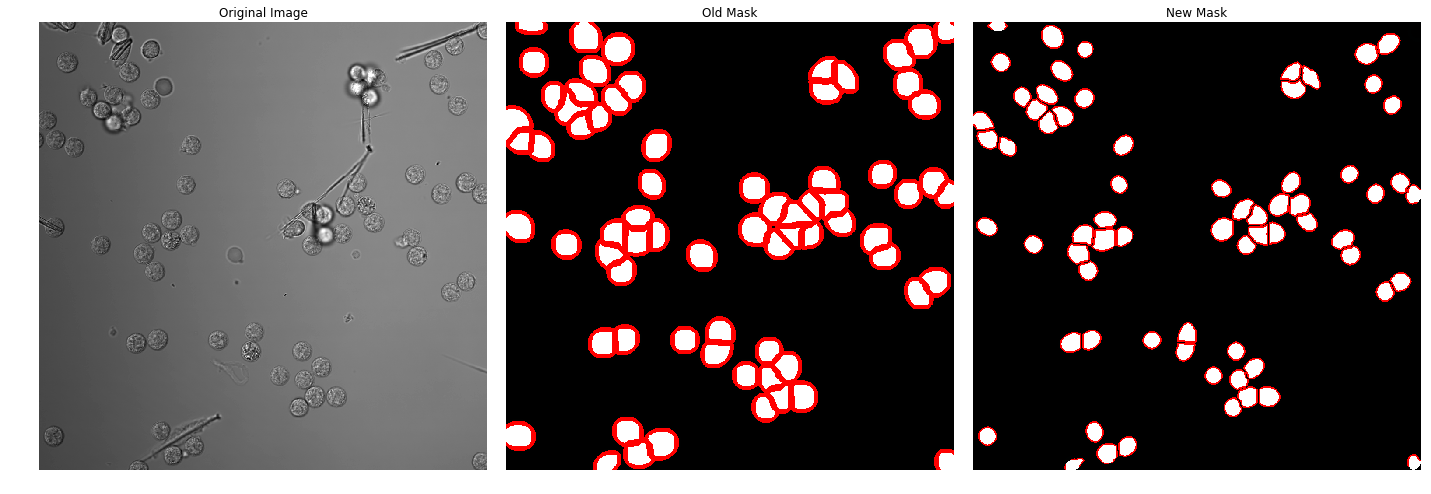

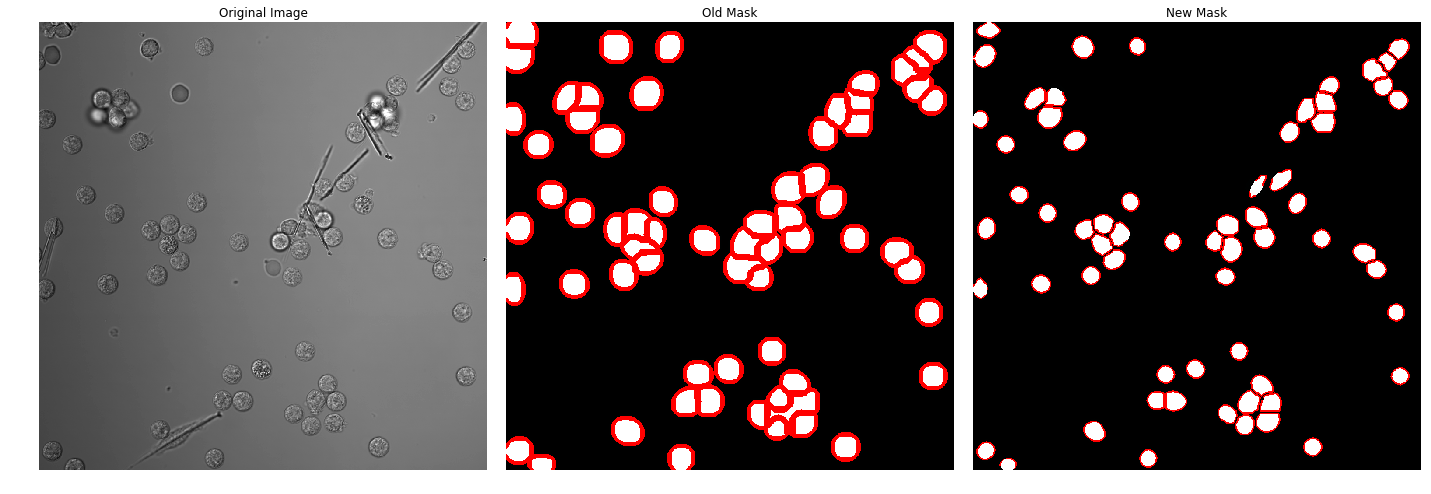

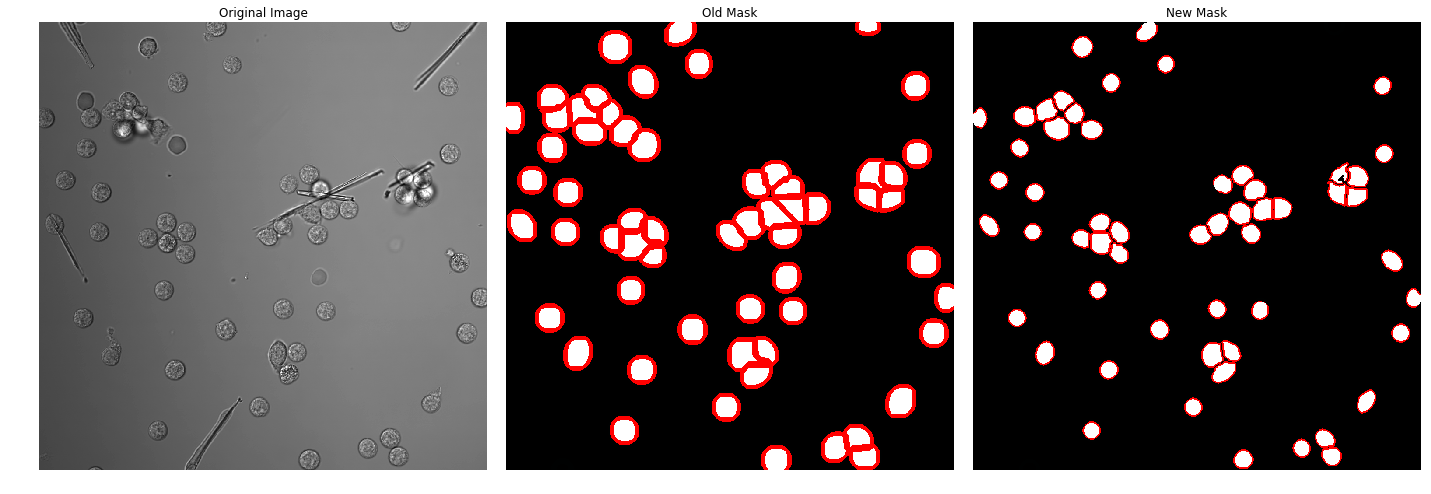

In [30]:
#3 - Display image, old_map, new_map

for i in range(3):

    fig, axes = plt.subplots(ncols=3, figsize=(20, 20), sharex=True, sharey=True,
                             subplot_kw={'adjustable': 'box-forced'})
    ax = axes.ravel()

    ax[0].set_title('Original Image')
    ax[0].imshow(images[i], interpolation='nearest')
    
    ax[1].set_title('Old Mask')
    ax[1].imshow(old_maps[i], interpolation='nearest')
    
    ax[2].set_title('New Mask')

    ax[2].imshow(new_maps[i], interpolation='nearest')
    
    for a in ax:
        a.set_axis_off()

    fig.tight_layout()
    plt.show()



### Labelling on new segmentation_maps

- Calculated the mean and std for all the labelled objects across all training images. 
- Objects that fall outside 2-standard deviations(except eccentricity) of these properties are thrown away. 
- Eccentricity=0 if circle, Eccentricity=1 if ellipse. We want to extract more circular patches, so have
 considered it to be from 0 to mean_eccentricity + 1 std 

In [34]:
mean = {
            'area':1430.736241,
            'eccentricity':0.507366,
            'major_axis_length':46.581709,
            'minor_axis_length':38.994317

}

std = {
            'area':376.554888,
            'eccentricity':0.159627,
            'major_axis_length':6.338599,
            'minor_axis_length':6.169081

}

In [35]:
# Calculate upper and lower limits

areall = mean['area'] - 2*std['area']
arearul = mean['area'] + 2*std['area']

major_axisll = mean['major_axis_length'] - 2*std['major_axis_length']
major_axisul = mean['major_axis_length'] + 2*std['major_axis_length']

minor_axisll = mean['minor_axis_length'] - 2*std['minor_axis_length']
minor_axisul = mean['minor_axis_length'] + 2*std['minor_axis_length']

eccentricityll = 0.01
eccentricityul = mean['eccentricity'] + 1*std['eccentricity']


No. of extracted regions: 41


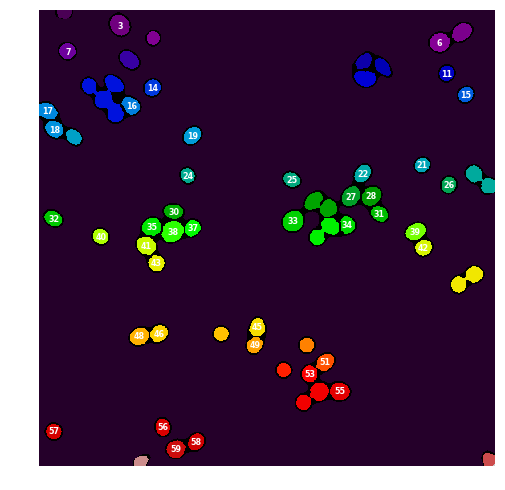

No. of extracted regions: 40


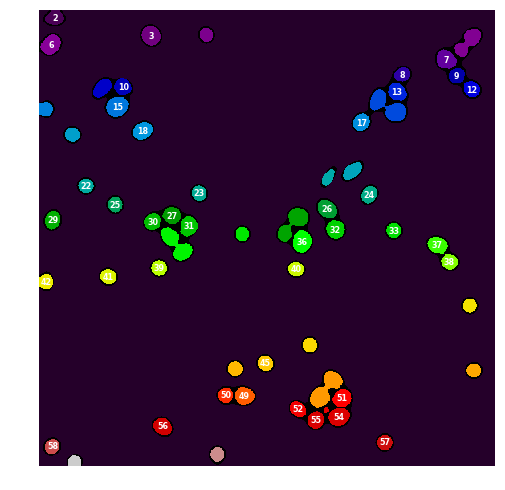

No. of extracted regions: 32


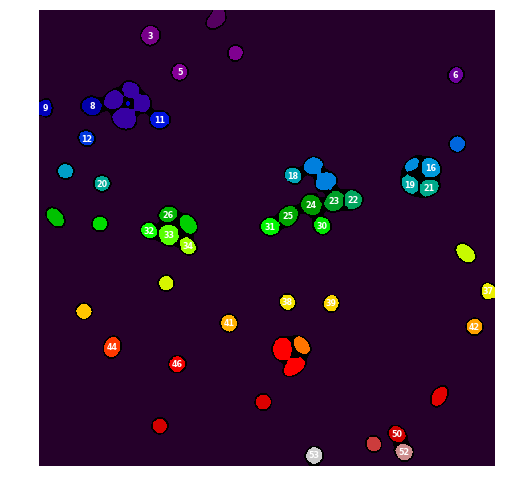

In [48]:
#Plot labelled regions
is_plot_whole = True
is_plot = False

for i1 in range(3):
    fgs= []   
    
    current_img = images[i1]
    current_img_gray = rgb2gray(current_img)
    current_img_gray_i = Image.fromarray((current_img_gray*255).astype('uint8'))
    current_img_gray_i = current_img_gray_i.resize((1024,1024),Image.BICUBIC)
    current_img_gray_arr = np.array(current_img_gray_i)
    
    current_mask = new_maps[i1]
    current_mask_gray = rgb2gray(current_mask)
    current_mask_gray_i = (current_mask_gray*255).astype('uint8')
      
    current_mask_gray_i = Image.fromarray(current_mask_gray_i).resize((1024,1024))
    current_mask_gray_arr = np.array(current_mask_gray_i)
    current_mask_gray_arr = median(current_mask_gray_arr, disk(11))
    
    #new_array1 = [tuple(row) for row in current_mask_gray_arr]
    #uniques1 = np.unique(new_array1)
    #print (uniques1)
    
    label_image = label(current_mask_gray_arr,background=54)
    image_label_overlay = label2rgb(label_image, image=current_img_gray_arr)
    region_props = regionprops(label_image,intensity_image=current_img_gray_arr)
    region_props = region_props[1:]
    
    extracted_regions = []
    extracted_region_indices = []
    
    for i2,region in enumerate(region_props):
        #print (region.area)
        if (
            (region.area > areall) and (region.area < arearul) and 
            (region.eccentricity > eccentricityll) and (region.eccentricity < eccentricityul) and 
            (region.major_axis_length > major_axisll) and (region.major_axis_length < major_axisul) and
            (region.minor_axis_length > minor_axisll) and (region.minor_axis_length < minor_axisul)
           ):
            extracted_regions.append(region.label)
            extracted_region_indices.append(i2)

    print ('No. of extracted regions: %d' % (len(extracted_regions)))
    if (len(extracted_regions) > 100):
        print (files[i1]+" has no. of extracted regions:%d" % (len(extracted_regions)))
        print (' ')
        continue
    
    if is_plot_whole:
        fig, ax = plt.subplots(figsize=(7, 7))
        ax.imshow(label_image,cmap='nipy_spectral')

        for i,r in enumerate(extracted_regions):
            region = get_from_region_props(region_props,r)
            if ((region.area > areall) and (region.area < arearul) and 
                (region.eccentricity > eccentricityll) and (region.eccentricity < eccentricityul) and 
                (region.major_axis_length > major_axisll) and (region.major_axis_length < major_axisul) and
                (region.minor_axis_length > minor_axisll) and (region.minor_axis_length < minor_axisul)
               ):
   
                cy,cx = region.centroid[0],region.centroid[1]

                ax.annotate(region.label, (cx, cy), color='w', weight='bold', fontsize=8, ha='center', va='center')


        ax.set_axis_off()
        plt.tight_layout()
        plt.show()
        
    

### Sample crops

In [92]:
#1 - Read some training images
cnt=0
img_files = []
crop_dir = '/media/narita/Data/Neutrophils/train_test_images/train_validation_combined/training_region_crops/neutrophils_train/neutrophils'
path = os.path.join(crop_dir)
img_files.insert(cnt,sorted(glob.glob(path+"/*.png")))
all_training_crops = [item for sublist in img_files for item in sublist]


In [93]:
random_img_ind =  np.random.randint(0,len(all_training_crops),size=18)
crops = []


for i,indx in enumerate(random_img_ind):
    current_crop = all_training_crops[indx]
    crops.insert(i,load_image(current_crop))



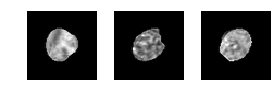

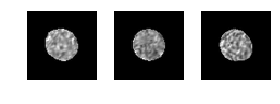

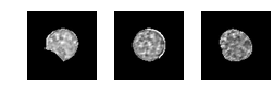

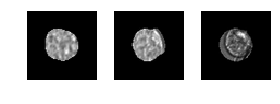

In [94]:
#3 - Display image, old_map, new_map
j=0
for i in range(4):
    
    fig, axes = plt.subplots(ncols=3,figsize=(4,4), sharex=True, sharey=True,
                             subplot_kw={'adjustable': 'box-forced'})
    ax = axes.ravel()

    ax[0].imshow(crops[j],cmap='gray', interpolation='nearest')
    j=j+1
    
    ax[1].imshow(crops[j+1],cmap='gray', interpolation='nearest')
    j=j+1
    
    ax[2].imshow(crops[j+2],cmap='gray', interpolation='nearest')
    j=j+1
    
    for a in ax:
        a.set_axis_off()
    
    
    fig.tight_layout()
    plt.show()



### WGAN Losses

In [105]:
from IPython.display import Image
from IPython.display import display

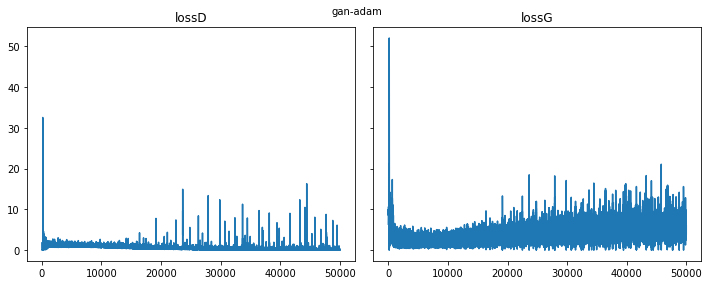

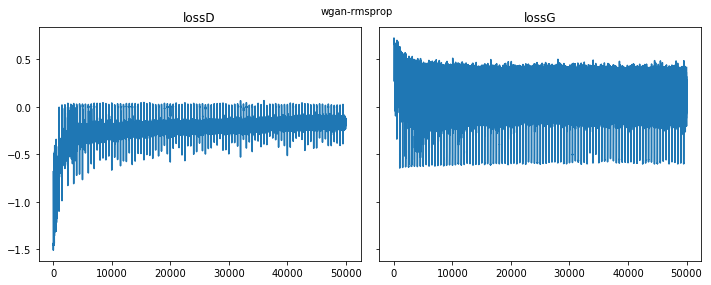

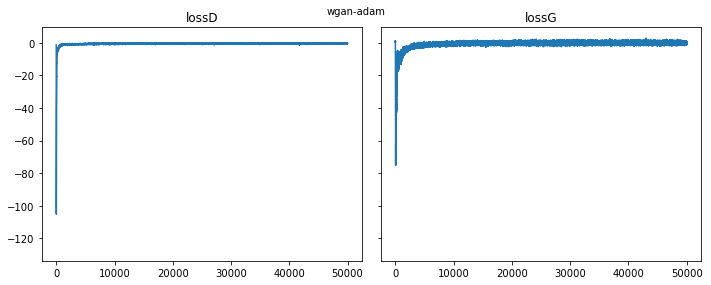

In [104]:
x = Image(filename='losses0.png') 
y = Image(filename='losses1.png') 
z = Image(filename='losses2.png')
display(x, y, z)